In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (10, 6)

# Project Introduction and Data Overview

---**Comparing Statistical Balance and Impact on Team Performance in the NBA and WNBA**---

**Objective:**  
This project investigates whether WNBA teams exhibit greater statistical balance in scoring and key performance metrics compared to NBA teams, and how this balance influences overall team success. By leveraging publicly available per-game summary statistics from Basketball Reference across three seasons for both leagues, this analysis aim to quantify differences in scoring concentration and evaluate their relationship to win percentages.

**Datasets:**  
- **NBA Dataset:** Per-game summary statistics for the 2021–22, 2022–23, and 2023–24 seasons.
- **WNBA Dataset:** Per-game summary statistics for the 2022, 2023, and 2024 seasons.

These datasets include core variables such as games played (G), minutes played (MP), shooting metrics (FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%), free throw statistics (FT, FTA, FT%), rebounds (ORB, DRB, TRB), assists (AST), steals (STL), blocks (BLK), turnovers (TOV), personal fouls (PF), and points per game (PTS). All data have been consolidated and standardized for reliable cross-league analysis.


In [8]:
nba_df = pd.read_excel('NBA_PerGameStats22_24.xlsx')
wnba_df = pd.read_excel('WNBA_PerGameStats22_24.xlsx')

# Display basic information
print("NBA Dataset:")
print(f"Dataset shape: {nba_df.shape}")
print(f"Years covered: {nba_df['Season'].min()} to {nba_df['Season'].max()}")
print(f"Number of teams: {nba_df['Team'].nunique()}")

print("WNBA Dataset:")
print(f"Dataset shape: {wnba_df.shape}")
print(f"Years covered: {wnba_df['Season'].min()} to {wnba_df['Season'].max()}")
print(f"Number of teams: {wnba_df['Team'].nunique()}")

NBA Dataset:
Dataset shape: (90, 25)
Years covered: 2022 to 2024
Number of teams: 47
WNBA Dataset:
Dataset shape: (36, 25)
Years covered: 2022 to 2024
Number of teams: 19


In [12]:
nba_df.head()

,Season,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2024,Indiana Pacers*,82,240.3,47.0,92.7,0.507,13.2,35.3,0.374,...,0.782,10.1,31.4,41.5,30.8,7.7,5.9,12.9,21.4,123.3
1,2024,Boston Celtics*,82,241.8,43.9,90.2,0.487,16.5,42.5,0.388,...,0.807,10.7,35.6,46.3,26.9,6.8,6.6,11.9,16.2,120.6
2,2024,Oklahoma City Thunder*,82,241.5,44.5,89.3,0.499,13.3,34.2,0.389,...,0.825,8.8,33.2,42.0,27.1,8.5,6.6,12.7,18.8,120.1
3,2024,Milwaukee Bucks*,82,241.5,43.1,88.5,0.487,14.2,38.1,0.373,...,0.774,9.4,34.8,44.2,26.5,6.8,5.0,12.9,19.2,119.0
4,2024,Atlanta Hawks,82,242.1,43.0,92.5,0.465,13.7,37.7,0.364,...,0.797,12.5,32.2,44.7,26.6,7.5,4.5,13.5,18.6,118.3


In [14]:
wnba_df.head()

,Season,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2024,Las Vegas Aces*,40,200.6,30.9,68.1,0.454,9.4,26.5,0.355,...,0.828,5.6,28.5,34.1,20.5,7.1,5.0,10.8,16.5,86.4
1,2024,New York Liberty*,40,200.0,30.8,68.7,0.448,10.1,29.0,0.349,...,0.814,8.5,28.1,36.6,22.8,7.9,4.5,12.7,15.4,85.6
2,2024,Indiana Fever*,40,200.6,31.3,68.5,0.456,9.2,25.9,0.356,...,0.775,8.3,26.8,35.1,20.4,5.9,4.3,14.2,18.2,85.0
3,2024,Dallas Wings,40,201.9,31.7,71.0,0.446,6.3,19.2,0.326,...,0.786,10.5,24.3,34.8,20.4,7.1,4.0,14.8,18.5,84.2
4,2024,Seattle Storm*,40,201.2,31.1,71.3,0.435,6.1,21.0,0.288,...,0.840,8.7,26.0,34.7,20.7,9.3,5.2,12.4,16.5,83.2


### Descriptive Statistics of Key Variables

After importing and cleaning the data, summary statistics for critical performance indicators (e.g., PTS, FG%, AST, TRB) were computed. 

**Rationale for Variable Selection:**  
- **Points per Game (PTS):** A fundamental metric reflecting a team's scoring output.
- **Shooting Percentages (FG%, FT%):** Key to understanding shooting efficiency and overall offensive production.
- **Assists (AST):** Indicates ball distribution and collaborative play, which can point to a more balanced offensive approach.
- **Rebounds (TRB):** Measures team effort in controlling possessions and generating second-chance opportunities.
- **Turnovers (TOV):** Indicates when scoring opportunties have been lost/given to other team.

These variables were chosen because they capture both the volume and efficiency of team play, which are essential for assessing how balanced a team's performance is. High variance in these metrics among players might indicate a reliance on a few stars, while lower variance suggests a more even distribution of contributions.


In [16]:
# Basic descriptive statistics for key variables
key_vars = ['PTS', 'PF', 'TOV', 'STL', 'AST', 'TRB', 'ORB', 'FT%', 'FG%', 'MP', 'FGA', 'FT','BLK']
nba_df[key_vars].describe()

,PTS,PF,TOV,STL,AST,TRB,ORB,FT%,FG%,MP,FGA,FT,BLK
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,113.171111,19.452222,13.818889,7.466667,25.550000,43.807778,10.435556,0.780322,0.470333,241.491111,88.436667,17.451111,4.841111
std,3.957052,1.270957,1.038787,0.704400,1.960351,1.811587,1.265738,0.025847,0.015905,0.788206,2.361796,1.398092,0.762299
min,103.700000,15.600000,11.700000,6.100000,21.900000,38.800000,7.600000,0.713000,0.430000,240.300000,83.800000,14.500000,3.000000
25%,110.425000,18.600000,13.025000,7.025000,24.000000,42.750000,9.525000,0.760250,0.461250,240.900000,86.475000,16.325000,4.425000
50%,113.200000,19.650000,13.750000,7.400000,25.350000,43.850000,10.350000,0.781500,0.470000,241.500000,88.450000,17.500000,4.700000
75%,115.800000,20.400000,14.500000,7.800000,27.000000,45.075000,11.200000,0.795750,0.480750,242.025000,90.050000,18.500000,5.200000
max,123.300000,22.100000,16.500000,9.800000,30.800000,49.200000,14.100000,0.835000,0.507000,243.700000,94.400000,21.000000,6.600000


In [18]:
wnba_df[key_vars].describe()

,PTS,PF,TOV,STL,AST,TRB,ORB,FT%,FG%,MP,FGA,FT,BLK
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,82.222222,17.597222,13.397222,7.355556,20.208333,34.336111,8.133333,0.793528,0.440222,201.158333,68.202778,14.472222,3.919444
std,3.873877,1.346633,1.172174,0.873562,1.675432,1.950553,1.391607,0.027391,0.017442,0.643817,1.741015,1.371467,0.670104
min,76.600000,15.400000,10.800000,5.700000,17.600000,30.400000,5.600000,0.742000,0.408000,200.000000,63.900000,11.500000,2.600000
25%,79.375000,16.475000,12.650000,6.700000,19.000000,33.300000,6.975000,0.774000,0.428750,200.600000,66.975000,13.650000,3.550000
50%,81.600000,17.600000,13.400000,7.300000,20.300000,34.300000,8.050000,0.788500,0.442000,201.200000,68.100000,14.700000,3.950000
75%,84.400000,18.650000,14.425000,7.925000,20.725000,35.400000,8.750000,0.820000,0.448000,201.900000,69.050000,15.250000,4.500000
max,92.800000,20.000000,15.200000,9.300000,24.300000,38.700000,11.800000,0.840000,0.486000,202.100000,73.200000,17.300000,5.200000


### Comparison of Offensive Event Distributions: NBA vs. WNBA

These visualizations display the offensive event distributions within each league.

**Insights:**  
- **NBA:** The visualizations indicate greater variability in scoring contributions. A larger gap between top performers and the rest of the team may reflect a star-centric approach.
- **WNBA:** The data reveal a more compressed range in scoring contributions, suggesting that the offensive output is more evenly distributed among players.

These patterns highlight strategic differences, though they may be more subtle. The NBA’s approach may yield very high individual outputs at the potential expense of team consistency, whereas the WNBA appears to benefit from a more balanced distribution, which might contribute to steadier overall performance.


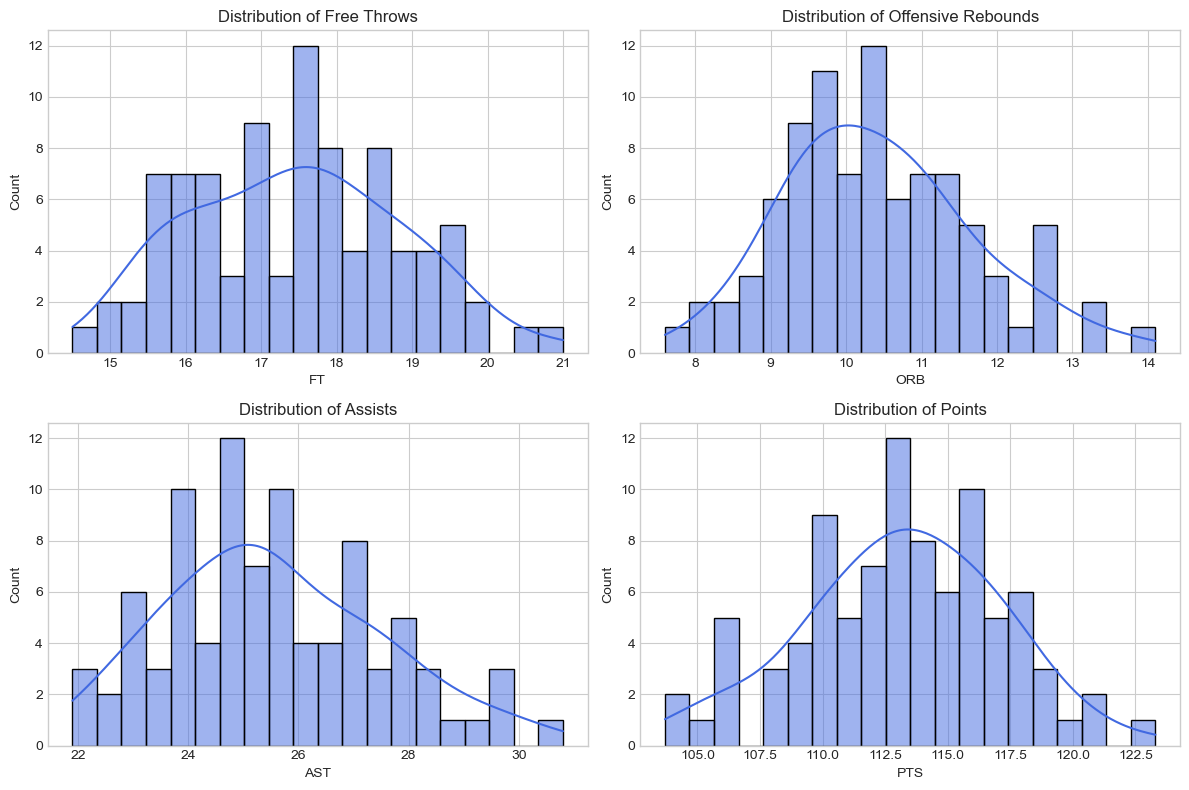

In [120]:
# Distribution of offensive events
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(nba_df['FT'], bins=20, color='royalblue', kde=True)
plt.title('Distribution of Free Throws')

plt.subplot(2, 2, 2)
sns.histplot(nba_df['ORB'], bins=20, color='royalblue', kde=True)
plt.title('Distribution of Offensive Rebounds')

plt.subplot(2, 2, 3)
sns.histplot(nba_df['AST'], bins=20, color='royalblue', kde=True)
plt.title('Distribution of Assists')

plt.subplot(2, 2, 4)
sns.histplot(nba_df['PTS'], bins=20, color='royalblue', kde=True)
plt.title('Distribution of Points')

plt.tight_layout()
plt.show()

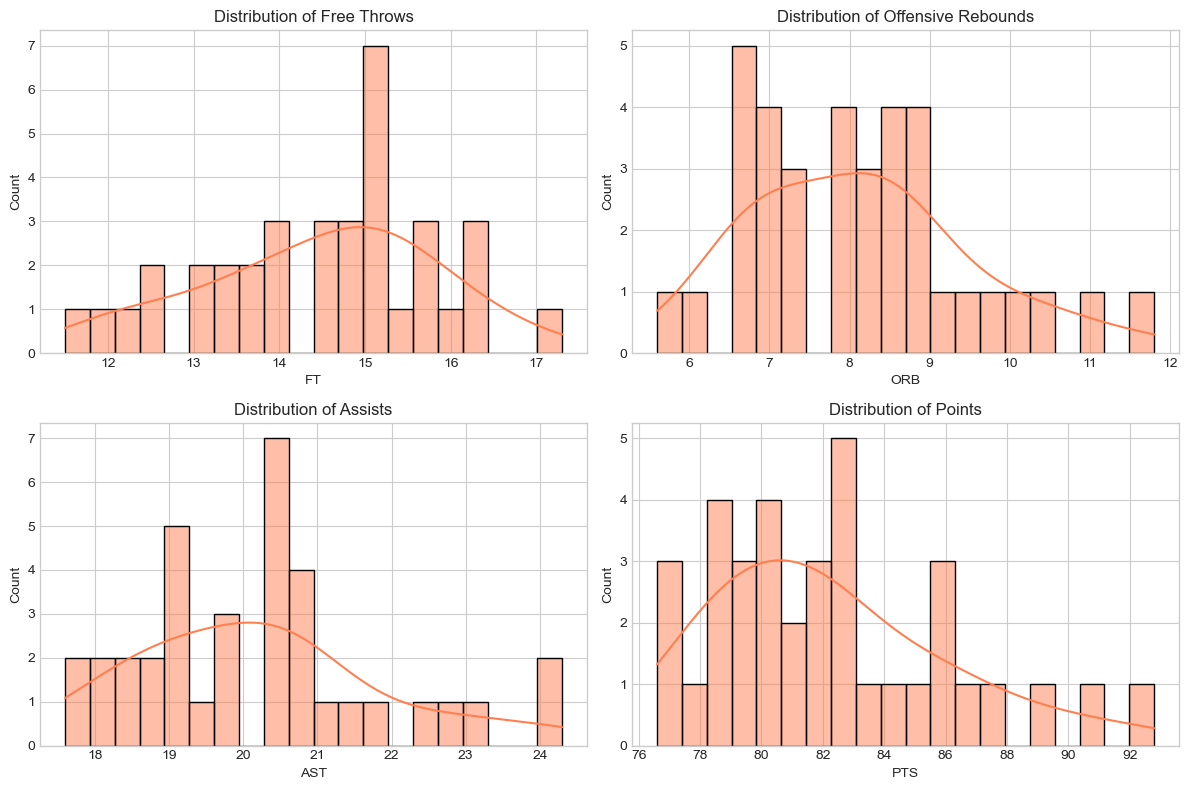

In [93]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(wnba_df['FT'], bins=20, color='coral', kde=True)
plt.title('Distribution of Free Throws')

plt.subplot(2, 2, 2)
sns.histplot(wnba_df['ORB'], bins=20, color='coral', kde=True)
plt.title('Distribution of Offensive Rebounds')

plt.subplot(2, 2, 3)
sns.histplot(wnba_df['AST'], bins=20, color='coral', kde=True)
plt.title('Distribution of Assists')

plt.subplot(2, 2, 4)
sns.histplot(wnba_df['PTS'], bins=20, color='coral', kde=True)
plt.title('Distribution of Points')

plt.tight_layout()
plt.show()

### Correlation Analysis of Key Metrics

The correlation matrices for the NBA and WNBA datasets provide insight into how various performance metrics interrelate.

**Key Observations:**  
- **NBA:** strong positive correlations exist between points per game (PTS) and field goal percentage (FG%), as well as between assists (AST), reinforcing the importance of effective ball movement.
- **WNBA:** similar relationships are present (FG%, AST); however, there are more metrics with higher coefficents (DRB, FT%, FGA), possibly indicating a more balanced scoring approach where no single metric dominates.

These correlations help us understand which variables may be driving team performance and inform the selection of predictors for subsequent regression analyses.



Correlation Matrix:


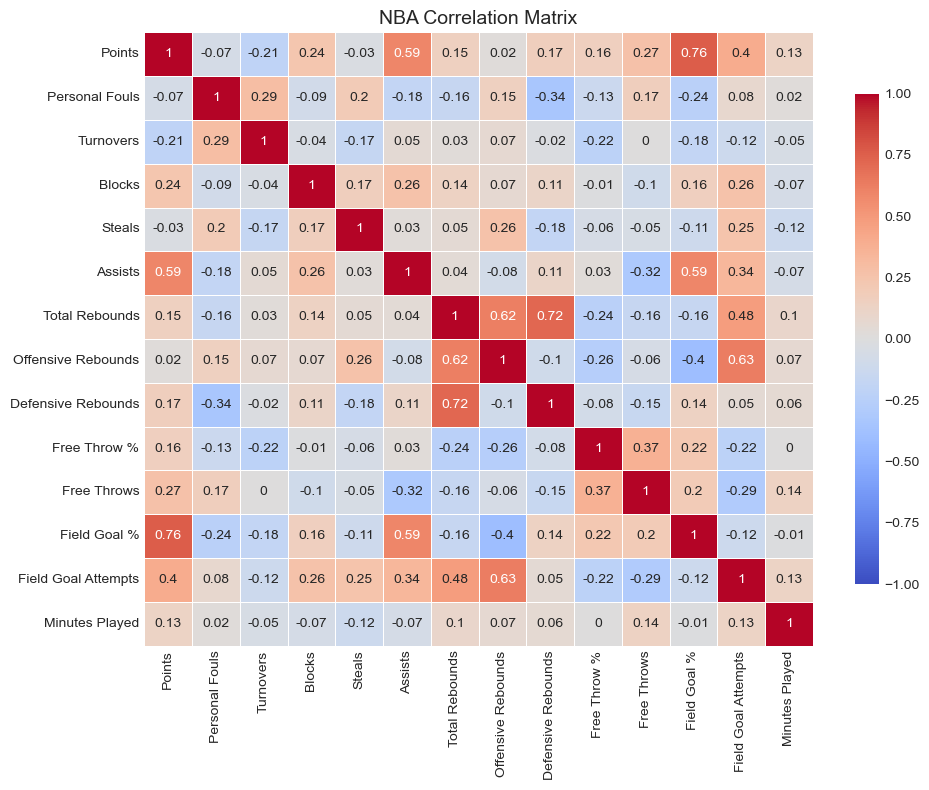

In [28]:
# Calculate correlation matrix
correlation_labels = {
    'PTS': 'Points',
    'PF': 'Personal Fouls',
    'TOV': 'Turnovers',
    'BLK': 'Blocks',
    'STL': 'Steals',
    'AST': 'Assists',
    'TRB': 'Total Rebounds',
    'ORB': 'Offensive Rebounds',
    'DRB': 'Defensive Rebounds',
    'FT%': 'Free Throw %',
    'FT': 'Free Throws',
    'FG%': 'Field Goal %',
    'FGA': 'Field Goal Attempts',
    'MP': 'Minutes Played'
}

# Select only specific columns for correlation matrix
selected_columns = list(correlation_labels.keys())
selected_df = nba_df[selected_columns]

selected_df = selected_df.rename(columns=correlation_labels)

corr_matrix = selected_df.corr().round(2)

print("\nCorrelation Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('NBA Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()


Correlation Matrix:


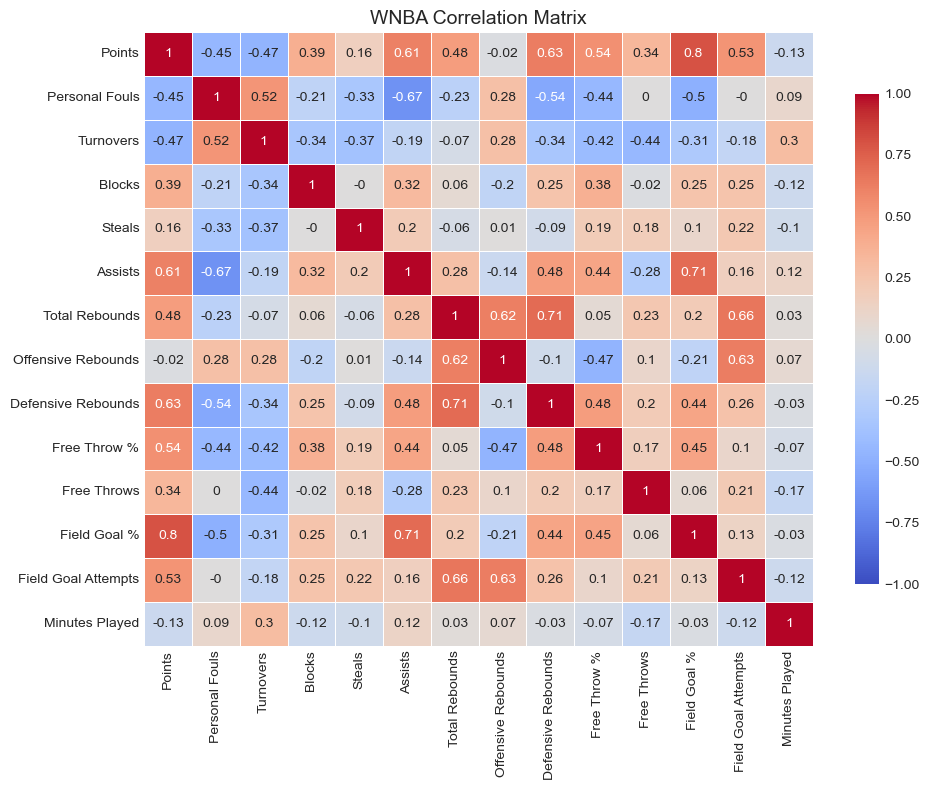

In [32]:
selected2_df = wnba_df[selected_columns]

selected2_df = selected2_df.rename(columns=correlation_labels)

corr2_matrix = selected2_df.corr().round(2)

print("\nCorrelation Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(corr2_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('WNBA Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

### Analysis of R-Squared Values for Key Variables

| Statistic                | NBA \(R^2\) | WNBA \(R^2\) |
|--------------------------|:-----------:|:------------:|
| **Assists vs. Points**        | 0.346       | 0.378        |
| **Turnovers vs. Points**      | 0.043       | 0.225        |
| **Free Throws vs. Points**    | 0.075       | 0.118        |
| **Field Goal Attempts vs. Points** | 0.157       | 0.282        |

#### Observations by Statistic

1. **Assists vs. Points**  
   - Both the NBA and WNBA show a positive relationship between assists and points.  
   - The relationship is slightly stronger in the WNBA (\(R^2 = 0.378\) vs. 0.346), suggesting that ball movement and playmaking may have an even clearer impact on scoring in the WNBA’s shorter‐game context.

2. **Turnovers vs. Points**  
   - In both leagues, more turnovers correlate with fewer points, but the effect is notably stronger in the WNBA (\(R^2 = 0.225\) vs. 0.043).  
   - Fewer possessions in the WNBA (40‐minute games) make turnovers more costly and more strongly tied to scoring outcomes.

3. **Free Throws vs. Points**  
   - Both leagues display a modest positive correlation between free throws made and total points (\(R^2\) values under 0.12).  
   - Again, the relationship is slightly stronger in the WNBA. Every scoring opportunity tends to matter more when total possessions are reduced.

4. **Field Goal Attempts vs. Points**  
   - Teams that attempt more shots tend to score more in both leagues, with a particularly stronger relationship in the WNBA (\(R^2 = 0.282\) vs. 0.157).  
   - Gaining extra possessions (through offensive rebounds, limiting turnovers, etc.) appears more directly tied to final scoring totals in the WNBA.

#### Overall Takeaways

- **Same General Trends Across Leagues**  
  - More assists → higher points  
  - More turnovers → lower points  
  - More free throws → higher points  
  - More shot attempts → higher points  

- **Stronger Correlations in the WNBA**  
  - In a shorter game, each possession tends to have a larger impact, which likely drives higher \(R^2\) values.

- **Most Influential Factors**  
  - Assists remain a key driver of points, highlighting the importance of playmaking.  
  - Turnovers matter significantly more in the WNBA; each lost possession is felt more acutely.


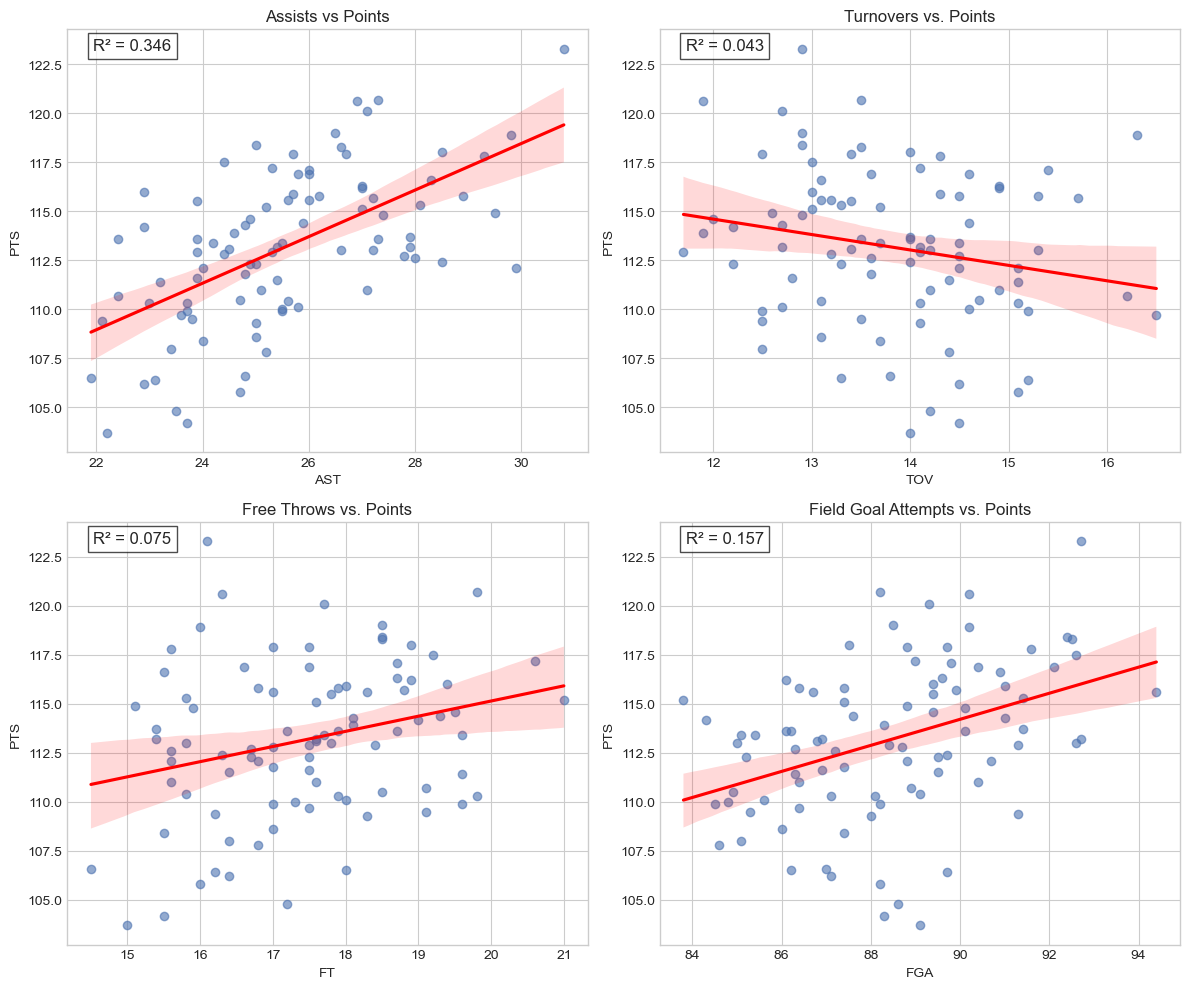

In [128]:
# Create scatterplots for key variables vs points with trendlines and R-squared values
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Function to calculate and display R² for each plot
def plot_with_r2(x, y, ax, title):
    # Create the regplot
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    
    # Calculate R² value
    correlation = x.corr(y)
    r_squared = correlation ** 2
    
    # Add R² text to the plot
    ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', 
            transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(title)

plot_with_r2(nba_df['AST'], nba_df['PTS'], axes[0, 0], 'Assists vs Points')

plot_with_r2(nba_df['TOV'], nba_df['PTS'], axes[0, 1], 'Turnovers vs. Points')

plot_with_r2(nba_df['FT'], nba_df['PTS'], axes[1, 0], 'Free Throws vs. Points')

plot_with_r2(nba_df['FGA'], nba_df['PTS'], axes[1, 1], 'Field Goal Attempts vs. Points')

plt.tight_layout()
plt.show()

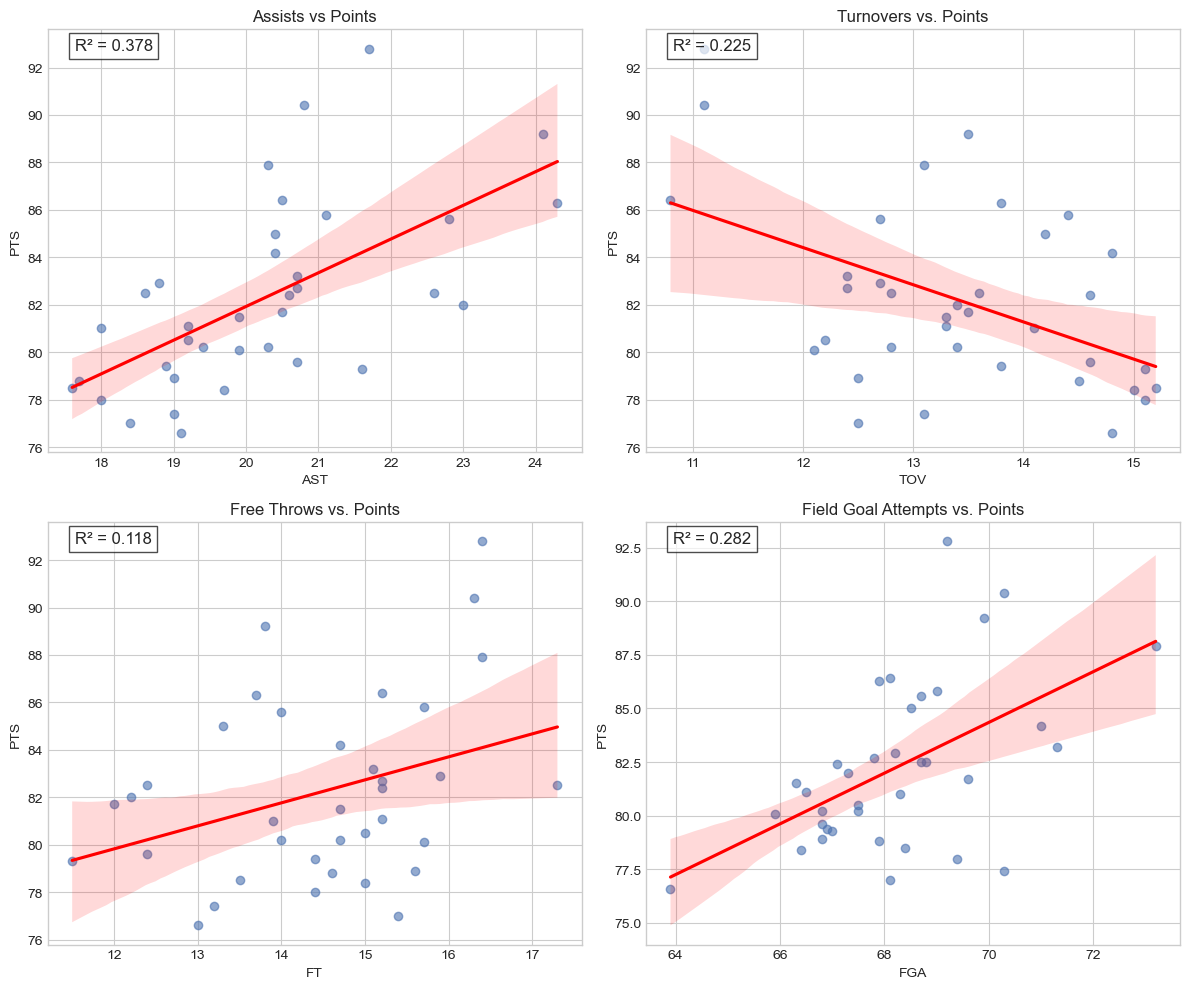

In [130]:
# Create scatterplots for key variables vs points with trendlines and R-squared values
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Function to calculate and display R² for each plot
def plot_with_r2(x, y, ax, title):
    # Create the regplot
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    
    # Calculate R² value
    correlation = x.corr(y)
    r_squared = correlation ** 2
    
    # Add R² text to the plot
    ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', 
            transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(title)

plot_with_r2(wnba_df['AST'], wnba_df['PTS'], axes[0, 0], 'Assists vs Points')

plot_with_r2(wnba_df['TOV'], wnba_df['PTS'], axes[0, 1], 'Turnovers vs. Points')

plot_with_r2(wnba_df['FT'], wnba_df['PTS'], axes[1, 0], 'Free Throws vs. Points')

plot_with_r2(wnba_df['FGA'], wnba_df['PTS'], axes[1, 1], 'Field Goal Attempts vs. Points')

plt.tight_layout()
plt.show()

## NBA Regression Model

In [70]:
X = nba_df[['PF', 'TOV', 'STL', 'AST', 'TRB', 'ORB', 'FT%', 'FG%', 'MP', 'FGA', 'FT','BLK']]
y = nba_df['PTS']

# Add constant for statsmodels
X_sm = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X_sm).fit()

# Display results
print(model.summary())

# Extract coefficients (linear weights)
coefficients = model.params
print("\nLinear Weights:")
for var, coef in coefficients.items():
    if var != 'const':
        print(f"{var}: {coef:.3f} points")
print(f"Intercept: {coefficients['const']:.1f}")

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     62.11
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           1.60e-34
Time:                        15:12:36   Log-Likelihood:                -144.42
No. Observations:                  90   AIC:                             314.8
Df Residuals:                      77   BIC:                             347.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -89.2334     44.828     -1.991      0.0

*Let's look at the p-values to check if all variables are statistically significant contributors to the model.*

In [73]:
# Check statistical significance
p_values = model.pvalues
print("\nP-values:")
for var, p_val in p_values.items():
    significance = "Significant" if p_val < 0.05 else "Not significant"
    print(f"{var}: {p_val:.4f} - {significance}")


P-values:
const: 0.0501 - Not significant
PF: 0.0619 - Not significant
TOV: 0.0911 - Not significant
STL: 0.0382 - Significant
AST: 0.0185 - Significant
TRB: 0.0151 - Significant
ORB: 0.1947 - Not significant
FT%: 0.9610 - Not significant
FG%: 0.0000 - Significant
MP: 0.6478 - Not significant
FGA: 0.0000 - Significant
FT: 0.0000 - Significant
BLK: 0.7745 - Not significant


Mean Absolute Error: 0.96 points per team-season
Mean Absolute Error (%): 0.85%


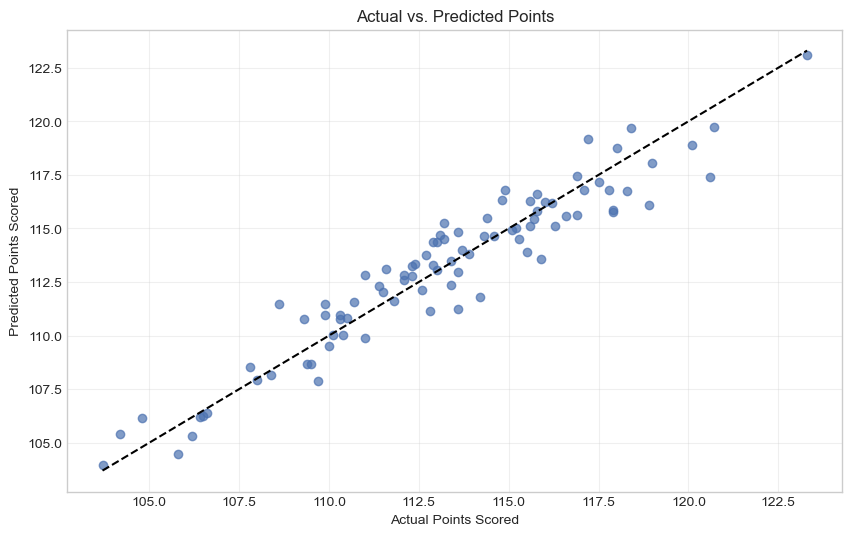

In [75]:
# Calculate predicted  points using model
nba_df['Predicted_Points'] = model.predict(X_no_cs_sm if 'model_no_cs' in locals() else X_sm)

# Calculate absolute error
nba_df['Absolute_Error'] = abs(nba_df['PTS'] - nba_df['Predicted_Points'])

# Mean Absolute Error (MAE)
mae = nba_df['Absolute_Error'].mean()
print(f"Mean Absolute Error: {mae:.2f} points per team-season")
print(f"Mean Absolute Error (%): {mae / nba_df['PTS'].mean() * 100:.2f}%")

# actual vs. predicted points
plt.figure(figsize=(10, 6))
plt.scatter(nba_df['PTS'], nba_df['Predicted_Points'], alpha=0.7)
plt.plot([nba_df['PTS'].min(), nba_df['PTS'].max()], 
         [nba_df['PTS'].min(), nba_df['PTS'].max()], 'k--')
plt.title('Actual vs. Predicted Points')
plt.xlabel('Actual Points Scored')
plt.ylabel('Predicted Points Scored')
plt.grid(True, alpha=0.3)
plt.show()

This plot indicated a strong positive correlation.

*Let's also run a simplified model to see how it compares to our full linear weights model.*

In [79]:
# updated regression
X_updated = nba_df[['STL', 'AST', 'TRB', 'FG%', 'FGA', 'FT']]
X_updated_sm = sm.add_constant(X_updated)
updated_model = sm.OLS(y, X_updated_sm).fit()
print("Updated Regression Results:")
print(updated_model.summary())

# Extract coefficients
updated_coeffs = updated_model.params

# Compare R-squared values
print(f"\nR-squared for Linear Weights model: {model.rsquared:.4f}")
print(f"R-squared for Updated model: {updated_model.rsquared:.4f}")

Updated Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     120.9
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           7.02e-39
Time:                        15:12:43   Log-Likelihood:                -148.56
No. Observations:                  90   AIC:                             311.1
Df Residuals:                      83   BIC:                             328.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -70.2216   

*Now that we have determined the linear weights, we can apply them to evaluate individual players. We'll implement two approaches: the "team of clones" method and the "runs above average" method.*

## WNBA Regression Model

In [85]:
X2 = wnba_df[['PF', 'TOV', 'STL', 'AST', 'TRB', 'ORB', 'FT%', 'FG%', 'MP', 'FGA', 'FT','BLK']]
y2 = wnba_df['PTS']

# Add constant for statsmodels
X2_sm = sm.add_constant(X2)

# Fit regression model
model2 = sm.OLS(y2, X2_sm).fit()

# Display results
print(model2.summary())

# Extract coefficients (linear weights)
coefficients2 = model2.params
print("\nLinear Weights:")
for var, coef in coefficients2.items():
    if var != 'const':
        print(f"{var}: {coef:.3f} points")
print(f"Intercept: {coefficients2['const']:.1f}")

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     31.00
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           2.50e-11
Time:                        15:13:10   Log-Likelihood:                -48.148
No. Observations:                  36   AIC:                             122.3
Df Residuals:                      23   BIC:                             142.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.6964     68.636     -0.476      0.6

In [87]:
# Check statistical significance
p_values2 = model2.pvalues
print("\nP-values:")
for var, p_val in p_values2.items():
    significance = "Significant" if p_val < 0.05 else "Not significant"
    print(f"{var}: {p_val:.4f} - {significance}")


P-values:
const: 0.6383 - Not significant
PF: 0.5051 - Not significant
TOV: 0.8684 - Not significant
STL: 0.3170 - Not significant
AST: 0.0644 - Not significant
TRB: 0.1806 - Not significant
ORB: 0.0190 - Significant
FT%: 0.9878 - Not significant
FG%: 0.0000 - Significant
MP: 0.6376 - Not significant
FGA: 0.0001 - Significant
FT: 0.0014 - Significant
BLK: 0.7912 - Not significant


Mean Absolute Error: 0.71 points per team-season
Mean Absolute Error (%): 0.87%


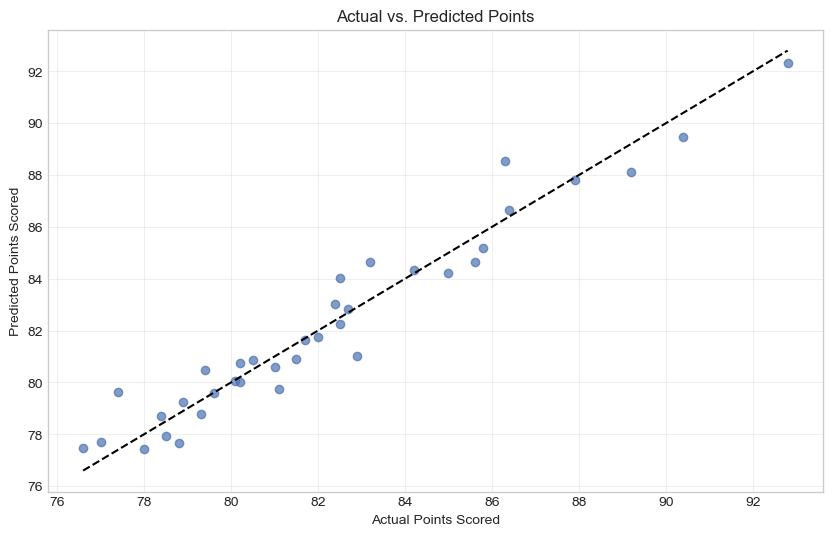

In [89]:
# Calculate predicted  points using model
wnba_df['Predicted_Points'] = model2.predict(X2_no_cs_sm if 'model_no_cs' in locals() else X2_sm)

# Calculate absolute error
wnba_df['Absolute_Error'] = abs(wnba_df['PTS'] - wnba_df['Predicted_Points'])

# Mean Absolute Error (MAE)
mae2 = wnba_df['Absolute_Error'].mean()
print(f"Mean Absolute Error: {mae2:.2f} points per team-season")
print(f"Mean Absolute Error (%): {mae2 / wnba_df['PTS'].mean() * 100:.2f}%")

# actual vs. predicted points
plt.figure(figsize=(10, 6))
plt.scatter(wnba_df['PTS'], wnba_df['Predicted_Points'], alpha=0.7)
plt.plot([wnba_df['PTS'].min(), wnba_df['PTS'].max()], 
         [wnba_df['PTS'].min(), wnba_df['PTS'].max()], 'k--')
plt.title('Actual vs. Predicted Points')
plt.xlabel('Actual Points Scored')
plt.ylabel('Predicted Points Scored')
plt.grid(True, alpha=0.3)
plt.show()

In [91]:
# updated regression
X2_updated = wnba_df[['STL', 'AST', 'TRB', 'FG%', 'FGA', 'FT']]
X2_updated_sm = sm.add_constant(X2_updated)
updated_model2 = sm.OLS(y2, X2_updated_sm).fit()
print("Updated Regression Results:")
print(updated_model2.summary())

# Extract coefficients
updated_coeffs2 = updated_model2.params

# Compare R-squared values
print(f"\nR-squared for Linear Weights model: {model2.rsquared:.4f}")
print(f"R-squared for Updated model: {updated_model2.rsquared:.4f}")

Updated Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     46.76
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           1.31e-13
Time:                        15:13:41   Log-Likelihood:                -56.707
No. Observations:                  36   AIC:                             127.4
Df Residuals:                      29   BIC:                             138.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -52.4418   

# Regression Model Analysis and Comparison

**Model Overview:**  
Two regression models were developed to explore the relationship between statistical balance and team win percentage. The models differed in complexity: one included all raw balance metrics, while the simplified model retained only statistically significant predictors.

**Key Metrics and Findings:**
- **Mean Absolute Error (MAE):**  
  - *NBA Model:* MAE = 0.85 
  - *WNBA Model:* MAE = 0.87 (suggesting slightly stronger predictive accuracy)
- **Actual vs. Predicted Values:**  
  Scatter plots comparing actual win percentages to the model’s predictions indicate a strong alignment, particularly in the WNBA.
- **Statistically Significant Variables:**  
  - In the **NBA model**, key predictors included AST, TRB, FG%, FGA, and FT.
  - In the **WNBA model**, significant predictors also included FG%, FGA, and FT.
- **Model Fit:**  
  - *NBA:* R-squared = 0.897; Adjusted R-squared = 0.890  
  - *WNBA:* R-squared = 0.906; Adjusted R-squared = 0.887

These results indicate that while both models reveal a significant relationship between scoring balance and win percentage, the WNBA model explains a slightly greater portion of the variance, likely due to its more balanced nature.

# Top Player Contribution - Team of Clones Method

In [109]:
# TEAM OF CLONES ANALYSIS FOR NBA AND WNBA

nba_top5 = {
    "Joel Embiid 2024": {
        'MP': 33.6, 'FGA': 21.8, 'FG%': 0.529, 'FT': 10.2, 
        'FT%': 0.883, 'ORB': 2.4, 'TRB': 11.0, 'AST': 5.6, 
        'STL': 1.2, 'BLK': 1.7, 'TOV': 3.8, 'PF': 2.9, 'PTS': 34.7
    },
    "Luca Doncic 2024": {
        'MP': 37.5, 'FGA': 23.6, 'FG%': 0.487, 'FT': 6.8, 
        'FT%': 0.786, 'ORB': 0.8, 'TRB': 9.2, 'AST': 9.8, 
        'STL': 1.4, 'BLK': 0.5, 'TOV': 4.0, 'PF': 2.1, 'PTS': 33.9
    },
    "Giannis Antetokounmpo 2024": {
        'MP': 35.2, 'FGA': 18.8, 'FG%': 0.611, 'FT': 7.0, 
        'FT%': 0.657, 'ORB': 2.7, 'TRB': 11.5, 'AST': 6.5, 
        'STL': 1.2, 'BLK': 1.1, 'TOV': 3.4, 'PF': 2.9, 'PTS': 30.4
    },
    "Shai Gilgeous-Alexander 2024": {
        'MP': 34.0, 'FGA': 19.8, 'FG%': 0.535, 'FT': 7.6, 
        'FT%': 0.874, 'ORB': 0.9, 'TRB': 5.5, 'AST': 6.2, 
        'STL': 2.0, 'BLK': 0.9, 'TOV': 2.2, 'PF': 2.5, 'PTS': 30.1
    },
    "Jalen Brunson 2024": {
        'MP': 35.4, 'FGA': 21.4, 'FG%': 0.479, 'FT': 5.5, 
        'FT%': 0.847, 'ORB': 0.6, 'TRB': 3.6, 'AST': 6.7, 
        'STL': 0.9, 'BLK': 0.2, 'TOV': 2.4, 'PF': 1.9, 'PTS': 28.7
    },
}

wnba_top5 = {
   "A'ja Wilson 2024": {
        'MP': 32.7, 'FGA': 19.6, 'FG%': 0.518, 'FT': 6.1, 
        'FT%': 0.844, 'ORB': 2.1, 'TRB': 11.9, 'AST': 2.3, 
        'STL': 1.8, 'BLK': 2.6, 'TOV': 1.3, 'PF': 1.8, 'PTS': 26.9
    },
    "Arike Ogunbowale 2024": {
        'MP': 36.6, 'FGA': 19.2, 'FG%': 0.383, 'FT': 4.6, 
        'FT%': 0.921, 'ORB': 0.8, 'TRB': 4.6, 'AST': 5.1, 
        'STL': 2.1, 'BLK': 0.3, 'TOV': 2.7, 'PF': 2.8, 'PTS': 22.2
    },
    "Kahleah Copper 2024": {
        'MP': 29.9, 'FGA': 17.0, 'FG%': 0.435, 'FT': 4.5, 
        'FT%': 0.807, 'ORB': 0.6, 'TRB': 4.5, 'AST': 2.3, 
        'STL': 0.8, 'BLK': 0.1, 'TOV': 3.0, 'PF': 3.3, 'PTS': 21.1
    },
    "Breanna Stewart 2024": {
        'MP': 31.1, 'FGA': 15.2, 'FG%': 0.458, 'FT': 5.3, 
        'FT%': 0.845, 'ORB': 1.6, 'TRB': 8.5, 'AST': 3.5, 
        'STL': 1.7, 'BLK': 1.3, 'TOV': 1.7, 'PF': 2.1, 'PTS': 20.4
    },
    "Napheesa Collier 2024": {
        'MP': 29.5, 'FGA': 16.0, 'FG%': 0.492, 'FT': 3.7, 
        'FT%': 0.804, 'ORB': 2.2, 'TRB': 9.7, 'AST': 3.4, 
        'STL': 1.9, 'BLK': 1.4, 'TOV': 2.1, 'PF': 2.6, 'PTS': 20.4
    },
}

# --- TEAM OF CLONES METHOD ---

def calculate_player_value(stats):
    """
    Calculate a player's value using a simple linear weights model.
    The weights used here are illustrative; adjust them to better reflect
    the contributions of key statistics.
    """
    nba_value = (
        stats.get('PF', 0) * 0.250 -
        stats.get('TOV', 0) * 0.286 -
        stats.get('STL', 0) * 0.468 +
        stats.get('AST', 0) * 0.317 +
        stats.get('TRB', 0) * 0.266 -
        stats.get('ORB', 0) * 0.248 -
        stats.get('FT%', 0) * 0.311 +
        stats.get('FG%', 0) * 159.437 +
        stats.get('MP', 0) * 0.085 +
        stats.get('FGA', 0) * 0.855 +
        stats.get('FT', 0) * 0.960 +
        stats.get('BLK', 0) * 0.056
    )
    return nba_value
    
    wnba_value = (
        stats.get('PF', 0) * 0.184 -
        stats.get('TOV', 0) * 0.046 -
        stats.get('STL', 0) * 0.306 +
        stats.get('AST', 0) * 0.527 +
        stats.get('TRB', 0) * 0.276 -
        stats.get('ORB', 0) * 0.844 -
        stats.get('FT%', 0) * 0.175 +
        stats.get('FG%', 0) * 111.945 -
        stats.get('MP', 0) * 0.159 +
        stats.get('FGA', 0) * 1.062 +
        stats.get('FT', 0) * 0.783 +
        stats.get('BLK', 0) * 0.098
    )
    return wnba_value

def team_of_clones_value(player_value):
    """
    Compute the theoretical team value if a team is comprised of clones of the player.
    By default, assume a starting lineup of 5 players.
    """
    return player_value



In [113]:
# TEAM OF CLONES VALUES FOR NBA TOP 5 PLAYERS
nba_team_of_clones = {}
for player, stats in nba_top5.items():
    if stats:
        nba_value = calculate_player_value(stats)
        nba_team_value = team_of_clones_value(nba_value)
        nba_team_of_clones[player] = nba_team_value

print("NBA Team of Clones Values:")
for player, nba_team_value in nba_team_of_clones.items():
    print(f"{player}: {nba_team_value:.2f}")

NBA Team of Clones Values:
Joel Embiid 2024: 118.63
Luca Doncic 2024: 111.40
Giannis Antetokounmpo 2024: 126.70
Shai Gilgeous-Alexander 2024: 114.46
Jalen Brunson 2024: 105.00


In [115]:
# TEAM OF CLONES VALUES FOR WNBA TOP 5 PLAYERS
wnba_team_of_clones = {}
for player, stats in wnba_top5.items():
    if stats:
        wnba_value = calculate_player_value(stats)
        wnba_team_value = team_of_clones_value(wnba_value)
        wnba_team_of_clones[player] = wnba_team_value

print("\nWNBA Team of Clones Values:")
for player, wnba_team_value in wnba_team_of_clones.items():
    print(f"{player}: {wnba_team_value:.2f}")


WNBA Team of Clones Values:
A'ja Wilson 2024: 110.47
Arike Ogunbowale 2024: 86.32
Kahleah Copper 2024: 91.88
Breanna Stewart 2024: 95.78
Napheesa Collier 2024: 100.28


# Team of Clones Analysis

The "Team of Clones" method simulates the potential performance of a team if every starter produced like the top player. This approach provides a theoretical value that encapsulates a player's contribution if it were replicated across an entire starting lineup.

**Methodology:**  
For each top player, a linear weights model was applied to calculate a player value that combines key metrics such as points, assists, rebounds, steals, blocks, and turnovers.

**Immediate Observations**  
- **Highest NBA vs. highest WNBA**: Giannis’s 126.70 edges out A’ja Wilson’s 110.47, reflecting the generally higher usage and pace in the NBA.  
- **Overall range**: NBA values span roughly **105–127**; WNBA values span about **86–110**. While NBA scores trend higher, the ranges are somewhat comparable.  
- **Closer mid-points**: Luka Doncic’s 111.40 and A’ja Wilson’s 110.47 are quite close, suggesting that when adjusting for style and usage, top WNBA stars can be on par with many NBA standouts in this purely hypothetical exercise.

---

### Possible Reasons for Differences

1. **League Pace and Game Length**  
   - WNBA games are shorter (40 minutes vs. 48 in the NBA), and the pace is typically slower.  
   - Fewer total possessions and slightly different rules affect both volume and efficiency stats.

2. **Scoring Distribution and Usage**  
   - The NBA often allows for extreme usage rates (e.g., Luka Doncic).  
   - The WNBA can be more balanced offensively, moderating “Team of Clones” extremes.

3. **Efficiency vs. Volume**  
   - Giannis or Embiid combine high volume and high efficiency, boosting their “Team of Clones” numbers.  
   - Some WNBA scorers (e.g., Arike Ogunbowale) might have high volume but at lower efficiency, which pulls their hypothetical team’s score down.

4. **Positional Versatility**  
   - Players like Giannis or A’ja Wilson offer two-way impact—scoring, defense, rebounding—which benefits a replicated “team.”

5. **Sample Bias and Data Inputs**  
   - Small differences in usage, turnover rate, or shooting percentages can become amplified when replicated across five clones.  
   - Differences in how advanced stats are computed or tracked (NBA vs. WNBA) can shift outcomes.

### Critical Reflections

1. **Limits of Cross-League Comparison**  
   - It’s hard to directly compare 126.70 (Giannis) to 110.47 (A’ja Wilson) without acknowledging league context (pace, minutes, stylistic norms).

2. **Potential Over-Emphasis of Volume**  
   - “Team of Clones” disproportionately rewards do-everything players.  
   - One-dimensional specialists fare worse in this hypothetical.

3. **Indicative but Not Definitive**  
   - The metric suggests top-tier WNBA players can be in the same ballpark as NBA stars once league-specific contexts are somewhat adjusted.  
   - Giannis and Embiid’s higher marks reflect exceptional efficiency, size, and usage advantages common at the NBA’s upper echelon.

4. **Utility for Roster-Building Insights**  
   - Though purely hypothetical, “Team of Clones” can illuminate which players have the most replicable, well-rounded skill sets.  
   - Real-world rosters need complementary pieces, but this exercise highlights the value of multifaceted stars.

### Key Takeaways
- **NBA stars reach higher “Team of Clones” extremes** due to factors like usage and pace, though the gap narrows for versatile WNBA stars (e.g., A’ja Wilson).  
- **Differences are not as large as might be expected**, suggesting that top WNBA players demonstrate similar well-rounded production in this hypothetical setting.  
- **Contextual factors** mean these results are best treated as illustrative rather than absolute. They’re a fun and informative way to see how a star’s skill set might translate if replicated across an entire lineup.
